# 3 Pre-Processing & Training

In our last step, we did some joining of our data based on latitude and longitude and explored our features. In this next step we will prepare for modeling by tuning our features, and maybe even adding a feature or two. We will have some challenges with finding the right mix and tuning of features when our initial correlation review didn't show much to work with. Maybe more challenging will be how to deal with our fairly imbalanced data.

## 3.0 Imports

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, recall_score
from sklearn import __version__ as sklearn_version

from imblearn.over_sampling import SMOTENC #using SMOTENC because it accepts a mix of numeric and categorical values

#imports for saving model
import os
import pickle

## 3.1 Load Data

In [24]:
trees_df = pd.read_csv('../data/data_outputs/seattle_trees_explored.csv')

trees_df.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,237,1071.925479,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,237,1071.925479,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,237,1071.925479,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3


## 3.2 Prep DF for Train-Test split

We'll take another look at the columns, as we can likely drop the additional reference info from our climate 'prcp' data source. And then we'll split our dependent and independent variables.

### 3.2.0 Drop Unecessary Columns

We'll drop the reference cols from climate data like I mentioned above, but also the 'condition' column because it is duplicative of our target feature. Our tree_id because it has no more use. And our date cols, because we have the calculated age feature that will be our variable related to dates/ages.

In [25]:
#View our columns
trees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158004 entries, 0 to 158003
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               155133 non-null  object 
 1   most_recent_observation    157999 non-null  object 
 2   common_name                157332 non-null  object 
 3   long_trees                 158004 non-null  float64
 4   lat_trees                  158004 non-null  float64
 5   diameter_breast_height_CM  158004 non-null  float64
 6   condition                  158004 non-null  object 
 7   native                     158004 non-null  object 
 8   age_at_obs                 155128 non-null  float64
 9   condition_index            158004 non-null  float64
 10  nearest_station            158004 non-null  object 
 11  station_id                 158004 non-null  object 
 12  station_name               158004 non-null  object 
 13  lat_prcp                   15

In [26]:
#drop our columns that are reference from climate dataset and the original condition column (which we used to create our target index feature)
trees_df = trees_df.drop(columns=['nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'condition', 'planted_date','most_recent_observation','tree_id','long_trees','lat_trees','temp_min_normal','temp_max_normal','temp_range_normal']) #also drop some of the climate normals fields since they don't add anything

In [27]:
trees_df.columns

Index(['common_name', 'diameter_breast_height_CM', 'native', 'age_at_obs',
       'condition_index', 'adj_reports', 'norm_prcp_mm_total',
       'norm_snow_mm_total', 'distance_between', 'temp_avg_normal',
       'prcp_mm_normal'],
      dtype='object')

### 3.2.1 Sample Dataset to Make Size More Manageable
One model may not be too crazy, but running a gridsearch CV on hundreds of thousands of rows may be a bit much for me. I'll start with a sample of 10,000.

In [28]:
trees_sample = trees_df.sample(n=20000, replace=False, random_state=42)

### 3.2.2 Split Dependent and Independent Variables

In [29]:
# split data into X and y
X = trees_sample.drop(columns=['condition_index'])
y = trees_sample['condition_index']

## 3.3 Train-Test Split
We'll use an 80:20 split here

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16000, 10) (16000,) (4000, 10) (4000,)


## 3.4 Impute Missing Values

We will use the median for our age at observation and mode for common name.

### 3.4.0 Establish Simple Imputers

In [31]:
X_train.isna().sum()

common_name                   74
diameter_breast_height_CM      0
native                         0
age_at_obs                   302
adj_reports                    0
norm_prcp_mm_total             0
norm_snow_mm_total             0
distance_between               0
temp_avg_normal                0
prcp_mm_normal                 0
dtype: int64

In [32]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

### 3.4.1 Impute Values

In [33]:
#fit and transform
X_train['age_at_obs'] = num_imputer.fit_transform(X_train[['age_at_obs']])
X_train['common_name'] = cat_imputer.fit_transform(X_train[['common_name']])

In [34]:
#validate no missing values
X_train.isna().sum()

common_name                  0
diameter_breast_height_CM    0
native                       0
age_at_obs                   0
adj_reports                  0
norm_prcp_mm_total           0
norm_snow_mm_total           0
distance_between             0
temp_avg_normal              0
prcp_mm_normal               0
dtype: int64

## 3.5 Simple Feature Engineering

Before running a first test model, I'll do some basic feature engineering. After testing on a single model we'll move into doing further tuning.

### 3.5.1 Categorical Encoding

We'll need to encode our categorical features. And for our tree names, we'll likely need to group together some of the less frequent options so we don't overwhelm our model with a crazy number of columns.

In [35]:
cat_columns = trees_df.select_dtypes(include='object').columns

cat_columns

Index(['common_name', 'native'], dtype='object')

In [36]:
#view value_counts of common_name field
X_train['common_name'].value_counts()

Red maple                      543
Apple/crabapple                455
Purpleleaf plum variety        449
Norway maple                   428
(smooth) japanese maple        422
                              ... 
Chenmoui elm                     1
California (western) redbud      1
Lolanthe magnolia                1
Oriental spruce                  1
Black willow                     1
Name: common_name, Length: 562, dtype: int64

In [37]:
#how many of the 485 categories have less than 10 records?

vc = pd.DataFrame(X_train['common_name'].value_counts())

vc.reset_index(inplace=True)

vc[vc['common_name'] < 3].value_counts()

index                           common_name
(pink) idaho locust             1              1
Pyramidal (bolleana) white pop  1              1
Paw paw                         1              1
Pink spires crabapple           1              1
Pissard purpleleaf plum         1              1
                                              ..
Goat (french pink pussy) willo  1              1
Golden colonnade ginkgo         1              1
Golden weeping willow           1              1
Gray birch                      2              1
Zelkova                         2              1
Length: 168, dtype: int64

In [38]:
#view value_counts of common_name field
trees_df['native'].value_counts()

introduced             116127
no_info                 32616
naturally_occurring      9261
Name: native, dtype: int64

#### 3.5.1.0 Convert common_name Field to Group Names with < 25 Occurences

This will limit the number of columns we have. We won't do thes ame for the native field. We'll do it by defining a function that can be utilized later as well.

In [39]:
def group_categories(df, col, n_limit):
    """ Store categories in df[col] with counts less than the specified n and overwrite the corresponding values in the df with 'Other' """
    groups = df[col]
    group_counts = groups.value_counts()
    mask = groups.isin(group_counts[group_counts<n_limit].index)
    df.loc[mask, col] = 'Other'

In [40]:
#use our group categories feature on our X_train set
group_categories(X_train, 'common_name', 25)

X_train['common_name'].value_counts()

Other                      2718
Red maple                   543
Apple/crabapple             455
Purpleleaf plum variety     449
Norway maple                428
                           ... 
Black cottonwood             26
American (white) elm         26
Swamp white oak              26
Trident maple                26
Starlight dogwood            25
Name: common_name, Length: 130, dtype: int64

## 3.6 First Model

Now that we've done some basic tuning, let's do some transforming with the feature engineering tools we fit and run a logistic regression model to see what we get.

In [41]:
X_train.head()

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal
156185,(smooth) japanese maple,5.08,introduced,26.891723,61,1198.095616,0.000000,0.221192,53.2,960.628
80188,Parrotia persian ironwood,5.08,introduced,12.000246,3,1021.831781,98.580822,1.923192,53.8,926.846
96012,Shirotae flowering cherry,25.40,no_info,26.817799,80,1038.526507,0.000000,2.075823,53.2,960.628
10740,Red sunset red maple,25.40,introduced,28.734334,347,1138.700000,35.000000,1.956034,53.8,926.846
30650,Barked himalayan (jacque white,7.62,introduced,5.656516,341,984.500000,0.000000,0.879531,53.2,960.628


In [42]:
#Initialize Scalers and Transforms

ss_scaler = StandardScaler()
pow_trans = PowerTransformer()
ohe1 = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #one for our common_name column
ohe2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #one for our native column

Adding some steps here -> My encoding is either encoding all values or keeping the specified ones. I want to fit and transform my categorical and then load them back into the main dataframe for a complete dataframe with scaled and encoded data.

In [43]:
#ss_scaler, pow_trans, ohe
#transform with our ss_scaler
X_train[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']] = ss_scaler.fit_transform(X_train[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']])

#transform with our pow_trans
X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.fit_transform(X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])

#reset index to create clean join after encoding
X_train.reset_index(drop=True,inplace=True)

In [44]:
#transform with our categorical columns and create dataframes
X_train_cn = ohe1.fit_transform(X_train[['common_name']])
cn_df = pd.DataFrame(X_train_cn, columns=ohe1.categories_[0]) #indexing 0 here to grab only the column names

X_train_nat = ohe2.fit_transform(X_train[['native']])
nat_df = pd.DataFrame(X_train_nat, columns=ohe2.categories_[0])


In [45]:
print(X_train.shape)
print(cn_df.shape)
print(nat_df.shape)

(16000, 10)
(16000, 130)
(16000, 3)


In [46]:
#concat these two dataframes back into X_train and create new dataframe, dropping original categorical fields
X_train_transformed = pd.concat([X_train, cn_df, nat_df], axis=1,)

#drop original categorical fields
X_train_transformed.drop(columns=['common_name', 'native'], inplace=True)

In [47]:
X_train_transformed.shape

(16000, 141)

In [48]:
#Initiate and run logistic regression model

logreg = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1)

logreg.fit(X_train_transformed, y_train)

print(f'Accuracy on training data: {accuracy_score(logreg.predict(X_train_transformed), y_train):.2f}')

Accuracy on training data: 0.58


In [49]:
print("Classification Report for Training Data")
print(classification_report(y_train, logreg.predict(X_train_transformed)))

Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       264
         2.0       0.00      0.00      0.00       860
         3.0       0.44      0.18      0.26      3869
         4.0       0.59      0.93      0.72      8871
         5.0       0.55      0.11      0.18      2136

    accuracy                           0.58     16000
   macro avg       0.32      0.24      0.23     16000
weighted avg       0.51      0.58      0.49     16000



/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Decent accuracy, but it's because we're only predicting the most common values, which isn't suprising based on our imbalanced data. Let's work on addressing the imbalanced data.

## 3.7 Work on Imbalanced Data

### 3.7.0 Re-Process train-test and imputing values

In [50]:
#Re-establish X_train and y_train to be sure to not leake over scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#impute missing values
X_train['age_at_obs'] = num_imputer.fit_transform(X_train[['age_at_obs']])
X_train['common_name'] = cat_imputer.fit_transform(X_train[['common_name']])

#group categorical values
#use our group categories feature on our X_train set
group_categories(X_train, 'common_name', 3)


In [51]:
#use SMOTE to resample and balance our dataset
sm = SMOTENC(random_state=42, categorical_features=[0,2])
X_res, y_res = sm.fit_resample(X_train, y_train)

print(np.bincount(y_res))

print(X_res.shape)

[   0 8871 8871 8871 8871 8871]
(44355, 10)


### 3.7.0 Re-Run Model Using 'SMOTED' Data

#### 3.7.0.0 Create Pre-Processing Pipeline

With the SMOTE now complete, I want to setup a pipeline for easier processing, breaking these out by categorical and numerical.

In [65]:
#transformer for categorical variables
cat_features = ['common_name','native']
cat_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [66]:
#transformer for numerical variables we want to scale using StandardScaler - the more normally distributed ones
num_features_std = ['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']
num_transformer_std = Pipeline(
    [
        ('imputer_num_std', SimpleImputer(strategy='median')),
        ('scaler_std', StandardScaler())
    ]
)

In [67]:
#transformer for numerical variables we want to scale using PowerTransformer - the non-normally distributed ones
num_features_pwr = ['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']
num_transformer_pwr = Pipeline(
    [
        ('imputer_num_pwr', SimpleImputer(strategy='median')),
        ('scaler_pwr', PowerTransformer())
    ]
)

In [68]:
#combine in Column Transformer
preprocessor = ColumnTransformer(
    [
        ('categoricals', cat_transformer, cat_features),
        ('numericals_std', num_transformer_std, num_features_std),
        ('numbericals_pwr', num_transformer_pwr, num_features_pwr)
    ],
    remainder='passthrough'
)

In [69]:
#create a pipeline using our pre-processing column transforming and a Logistic Regrssion model
pipe = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', LogisticRegression())
    ]
)

#### 3.7.0.1 Run Pipeline with GridSearchCV

Continue our SMOTED test with a gridsearch on a few parameter options.

In [71]:
#setup parameters to test for a logistic regression model
params = {
    'clf__solver': ['liblinear'],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 1, 10, 100],
    'clf__random_state': [42]
}

In [89]:
#create our GridSearch object. I am thinking our evaluation measure would be best suited as precision. I want to penalize the model for predicting retention whne it isn't the case. But I will include f1 in the scoring and refit based on precision
cv = GridSearchCV(
    pipe,
    params,
    cv = 5,
    scoring = ['recall_macro', 'f1_macro'],
    refit = 'recall_macro'
)

In [90]:
#execute our GridSearch on the trainign data and check results
cv.fit(X_res, y_res)

print(f'Best Recall Score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')
print(f'Scores: {classification_report(y_res, cv.predict(X_res))}')

Best Recall Score: 0.454

Best parameter set: {'clf__C': 1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}

Scores:               precision    recall  f1-score   support

         1.0       0.54      0.66      0.59      8871
         2.0       0.45      0.39      0.42      8871
         3.0       0.37      0.30      0.33      8871
         4.0       0.48      0.37      0.42      8871
         5.0       0.45      0.59      0.51      8871

    accuracy                           0.46     44355
   macro avg       0.46      0.46      0.45     44355
weighted avg       0.46      0.46      0.45     44355



**Observations:**
\
Less overall accuracy, but this is a step in the right direction as our recall looks much better. With basically no hyperparamter tuning, we still have work to do.

## 3.8 Tuning

I tested out the pretty simple tuning but I'd actually like to do some different scaling depending on the feature in preperation for hyperparamter tuning. I'll do that now on my resampled dataframe.

### 3.8.1 Try Another Approach On Imbalanced Data

Rather than using my resamples SMOTE dataframe, I want to try applying all of the other transformations the same, but this time on my initial 10,000 record sample using RepeatedStratifiedKFold cross validation.

#### 3.8.1.1 Define Our Cross-Validation Method

In [58]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

#### 3.8.1.2 Define Model

In [59]:
#define model with our best params so far
logreg2 = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1)

#### 3.8.1.3 Fit and Score

In [60]:
logreg2.fit(X_train_transformed, y_train)
print(f'Accuracy on training data: {accuracy_score(logreg2.predict(X_train_transformed), y_train):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_train, logreg2.predict(X_train_transformed)))

Accuracy on training data: 0.58
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       264
         2.0       0.00      0.00      0.00       860
         3.0       0.44      0.18      0.26      3869
         4.0       0.59      0.93      0.72      8871
         5.0       0.55      0.11      0.18      2136

    accuracy                           0.58     16000
   macro avg       0.32      0.24      0.23     16000
weighted avg       0.51      0.58      0.49     16000



/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

**Observations:**

Using the StratifiedKFold didn't give us as good of results as using SMOTE, so we'll go back to that method going forward.

## 3.9 Try Different Models

The best we got with logistic regression was 47% accuracy. That leaves much to be desired, so let's try something other than this type of model. We'll use our X_res_scaled and y_res for consistency.

### 3.9.0 Test Set Performance Comparison

If we do some simple default setting comparison between KNeighbors, Decision Trees, and Random Forest, it could give us a good sense of where to focus our time going forward.

#### 3.9.0.0 Run Models

In [61]:
#list types of models to run
models = {'logreg': LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1),
          'knn': KNeighborsClassifier(),
          'dec_tree': DecisionTreeClassifier(),
          'rand_for': RandomForestClassifier(),
          'ada': AdaBoostClassifier(),
          'gradient': GradientBoostingClassifier()
          }

#create blank list to store results
results = []

In [62]:
#Loop through models, score and save
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True) #using KFold this time rather than setting up a whole GridSearch
    cv_results = cross_val_score(model, X_res_transformed, y_res, cv=kf)
    results.append(cv_results)

#### 3.9.0.1 Plot Results

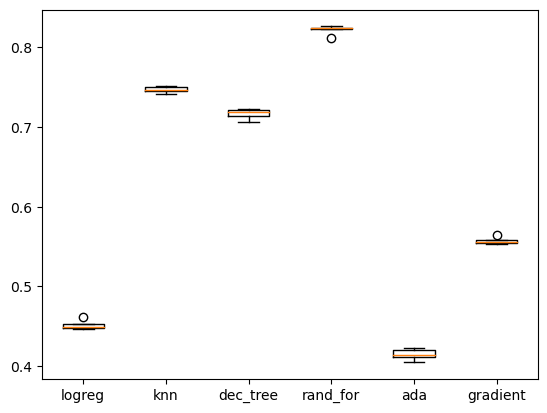

In [63]:
plt.boxplot(results, labels=models.keys())
plt.show()

**Observations:**
\
Our Random Forest looks to be the best option. Hopefully it's not ignoring all the minor classes. Let's explore this model futher.

### 3.9.1 Random Forest Classifier

This time I'll use RandomizedSearchCV to tune params. Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#### 3.9.1.0 Create Parameter Grid

In [99]:
#setup pipeline with random forest classifier
#create a pipeline using our pre-processing column transforming and a Logistic Regrssion model
pipe_rf = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', RandomForestClassifier())
    ]
)

In [106]:
#list out our different params
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 5)] #number of trees in the forest
max_features = ['sqrt'] #number of features to consider at each split
max_depth = [int(x) for x in np.linspace(5, 50, num=5)] #max levels in tree
min_samples_split = [2,5,10] #min samples required to split a node
min_samples_leaf = [1,2,4] #min samples at each leaf node
bootstrap = [True] #sampling method using bootsrap or not

#Create random grid
rand_grid = {'clf__n_estimators': n_estimators,
               'clf__max_depth': max_depth,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf}

print(rand_grid)

{'clf__n_estimators': [100, 137, 175, 212, 250], 'clf__max_depth': [5, 16, 27, 38, 50], 'clf__min_samples_split': [2, 5, 10], 'clf__min_samples_leaf': [1, 2, 4]}


#### 3.9.1.1 Fit with Random Search

In [107]:
rand_search = RandomizedSearchCV(pipe_rf, param_distributions=rand_grid, n_iter=10, cv=5, verbose=2, random_state=42) #sample using 10 param settings, 5-fold cross-val, computation time display

In [108]:
rand_search.fit(X_res, y_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=250; total time=   2.0s
[CV] END clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=250; total time=   2.0s
[CV] END clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=250; total time=   1.9s
[CV] END clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=250; total time=   1.9s
[CV] END clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=250; total time=   2.0s
[CV] END clf__max_depth=50, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=250; total time=  39.7s
[CV] END clf__max_depth=50, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=250; total time=  41.0s
[CV] END clf__max_depth=50, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categoricals',
                                                                               Pipeline(steps=[('imputer_cat',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['common_name',
                                                                                'native']),
                                                                              ('numericals_std',
                                                                               Pipeline(steps=[('imputer_num_std',
                                                                                                SimpleIm...
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler_pwr',
                                                                                                PowerTransformer())]),
                                                                               ['diameter_breast_height_CM',
                                                                                'norm_snow_mm_total',
                                                                                'distance_between',
                                                                                'adj_reports'])])),
                                             ('clf',
                                              RandomForestClassifier())]),
                   param_distributions={'clf__max_depth': [5, 16, 27, 38, 50],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': [100, 137, 175,
                                                              212, 250]},
                   random_state=42, verbose=2)

#### 3.9.1.2 Review Results

In [110]:
params = rand_search.best_params_

params

{'clf__n_estimators': 250,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 1,
 'clf__max_depth': 50}

In [111]:
#review scores
print(f'Accuracy on training data: {accuracy_score(rand_search.predict(X_res), y_res):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_res, rand_search.predict(X_res)))

Accuracy on training data: 1.00
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      8871
         2.0       1.00      1.00      1.00      8871
         3.0       1.00      1.00      1.00      8871
         4.0       0.99      1.00      0.99      8871
         5.0       1.00      1.00      1.00      8871

    accuracy                           1.00     44355
   macro avg       1.00      1.00      1.00     44355
weighted avg       1.00      1.00      1.00     44355



**Observations:**
\
Siri, what's the definition of overfitting? K Thanks. I've got a bad feeling about the test set but let's see how it goes!

### 3.9.2 Evaluate RF Model on Test Set

In [115]:
y_pred = rand_search.predict(X_test)

In [116]:
print(f'Accuracy on test data: {accuracy_score(y_pred, y_test):.2f}')
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))
print('----------------------------------------')
print(confusion_matrix(y_test, y_pred))

Accuracy on test data: 0.36
Classification Report for Test Data
              precision    recall  f1-score   support

         1.0       0.06      0.07      0.06        58
         2.0       0.07      0.04      0.05       224
         3.0       0.23      0.53      0.32       958
         4.0       0.57      0.41      0.48      2194
         5.0       0.23      0.02      0.04       566

    accuracy                           0.36      4000
   macro avg       0.23      0.21      0.19      4000
weighted avg       0.41      0.36      0.35      4000

----------------------------------------
[[   4    2   33   18    1]
 [  14    9  127   74    0]
 [  41   23  507  380    7]
 [  13   72 1173  903   33]
 [   0   21  333  200   12]]


**Observations:**
\
\
This is a much lower performance due to the overfitting. I'm curious to see the impact of different max depths visualized.

### 3.9.3 Visualize F1 Scores for Different Max Depths

#### 3.9.3.0 Re-Process Data To Avoid Leakage : SMOTE

In [117]:
#Train Test Split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape)

(16000, 10) (16000,) (4000, 10) (4000,)


In [118]:
#Initialize New Imputers
num_imputer_2 = SimpleImputer(strategy='median')
cat_imputer_2 = SimpleImputer(strategy='constant', fill_value='missing')

In [121]:
#Prep for SMOTE, impute missing and group categorical values
#impute missing values
X_train_final['age_at_obs'] = num_imputer_2.fit_transform(X_train_final[['age_at_obs']])
X_train_final['common_name'] = cat_imputer_2.fit_transform(X_train_final[['common_name']])

#group categorical values
#use our group categories feature on our X_train set
group_categories(X_train_final, 'common_name', 3)

In [119]:
X_train_final.shape

(16000, 10)

In [122]:
#SMOTE Data
#use SMOTE to resample and balance our dataset
sm = SMOTENC(random_state=42, categorical_features=[0,2])
X_res_final, y_res_final = sm.fit_resample(X_train_final, y_train_final)

print(np.bincount(y_res_final))

print(X_res_final.shape)

[   0 8871 8871 8871 8871 8871]
(44355, 10)


#### 3.9.3.3 Re-Process Data To Avoid Leakage : Encode Train & Test

In [123]:
#use our group categories feature on our X_train set
group_categories(X_test_final, 'common_name', 3)

In [124]:
X_test_final.shape

(4000, 10)

#### 3.9.3.1 Loop Through Different Maxes and Visualize Performance

In [126]:
#setup depth values to test
depth = np.arange(10,50,2) #setup max_depth values to test
depth

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 46, 48])

In [148]:
#create function to run pipeline with different depths
def create_pipeline_search(depth_n):
    #setup pipeline
    pipe_rf = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('clf', RandomForestClassifier(n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_depth=n))
        ]
    )
    #setup parms
    params_rf = {
        'clf__n_estimators': [250]
    }

    #setup grid search
    cv = GridSearchCV(
        pipe_rf,
        params_rf,
        cv = 5,
        scoring = ['recall_macro', 'f1_macro'],
        refit = 'recall_macro'
    )

    cv.fit(X_res_final, y_res)
    y_train_pred = cv.predict(X_res_final)
    y_test_pred = cv.predict(X_test)
    training_recall = recall_score(y_res, y_train_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')

    return {'train': training_recall, 'test': test_recall}

In [154]:
#Loop through and store outputs Runs slow - about 45 mins
train = {}
test = {}

for n in depth:
    results_dict = create_pipeline_search(n)
    train[n] = results_dict['train']
    test[n] = results_dict['test']

In [155]:
#which depth produced the best f1 score
best_depth = "Best Depth Performance: " + str(max(test, key=test.get))

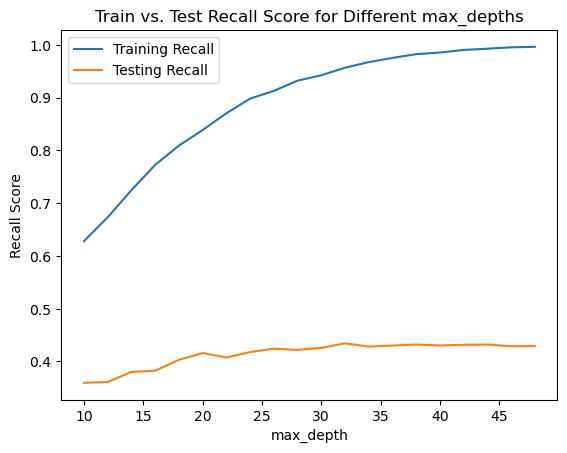

Best Depth Performance: 32


In [156]:
#Visualize
plt.plot(list(train.keys()),list(train.values()), label='Training Recall')
plt.plot(list(test.keys()),list(test.values()), label='Testing Recall')

plt.xlabel('max_depth')
plt.ylabel('Recall Score')
plt.title('Train vs. Test Recall Score for Different max_depths')
plt.legend()
plt.show()

print(best_depth)


It looks like training recall hits 100% at about 40 so we could try that. Even though best score is on 32, I don't want to pick that as it may just be on this specific test set. I'd rather not get in the habit of tuning on the test set. ;)

### 3.9.4 Run GridSearchCV On Other Hyper Params with a few Max_Depths up to 40.
I want to try GridSearchCV (instead of Randomized), this time limiting the search between 10 and 25 max_depth where we get the biggest lift. We're getting close to a final model, and I think this will be the last search run.

#### 3.9.4.0 Set Grid Params

In [160]:
#list out our different params
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)] #number of trees in the forest
max_depth = [int(x) for x in np.linspace(start = 10, stop = 25, num =5)]
min_samples_split = [2] #min samples required to split a node
min_samples_leaf = [1] #min samples at each leaf node

#Create random grid
rand_grid2 = {'clf__n_estimators': n_estimators,
               'clf__max_depth': max_depth,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf}

print(rand_grid2)

{'clf__n_estimators': [100, 125, 150, 175, 200], 'clf__max_depth': [10, 13, 17, 21, 25], 'clf__min_samples_split': [2], 'clf__min_samples_leaf': [1]}


#### 3.9.4.1 Run GridSearchCV

In [161]:
#create our GridSearch object. I am thinking our evaluation measure would be best suited as precision. I want to penalize the model for predicting retention whne it isn't the case. But I will include f1 in the scoring and refit based on precision
cv = GridSearchCV(
    pipe_rf,
    rand_grid2,
    cv = 5,
    scoring = ['recall_macro', 'f1_macro'],
    refit = 'recall_macro'
)

In [162]:
cv.fit(X_res_final, y_res_final)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categoricals',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['common_name',
                                                                          'native']),
                                                                        ('numericals_std',
                                                                         Pipeline(steps=[('imputer_num_std',
                                                                                          SimpleImputer(...
                                                                                         ('scaler_pwr',
                                                                                          PowerTransformer())]),
                                                                         ['diameter_breast_height_CM',
                                                                          'norm_snow_mm_total',
                                                                          'distance_between',
                                                                          'adj_reports'])])),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': [10, 13, 17, 21, 25],
                         'clf__min_samples_leaf': [1],
                         'clf__min_samples_split': [2],
                         'clf__n_estimators': [100, 125, 150, 175, 200]},
             refit='recall_macro', scoring=['recall_macro', 'f1_macro'])

#### 3.9.4.2 Review Best Params

In [163]:
params = cv.best_params_ #return best parameters from my gridsearch cv

params

{'clf__max_depth': 25,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 175}

#### 3.9.4.3 Run With Best Params

In [166]:
#Run a fit with those params and view more details scoring

#review scores
print(f"""Recall on training data: {recall_score(cv.predict(X_res_final), y_res_final, average='macro'):.2f}""")
print("Classification Report for Training Data")
print(classification_report(y_res_final, cv.predict(X_res_final)))

Recall on training data: 0.90
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.98      0.95      0.96      8871
         2.0       0.97      0.90      0.93      8871
         3.0       0.90      0.84      0.87      8871
         4.0       0.81      0.87      0.84      8871
         5.0       0.86      0.93      0.89      8871

    accuracy                           0.90     44355
   macro avg       0.90      0.90      0.90     44355
weighted avg       0.90      0.90      0.90     44355



#### 3.9.4.4 Run on Test Set

In [167]:
#predict using tune model
y_pred = cv.predict(X_test_final)

print(f"""Recall on test data: {recall_score(cv.predict(X_test_final), y_test_final, average='macro'):.2f}""")
print("Classification Report for Test Data")
print(classification_report(y_test_final, cv.predict(X_test_final)))
print('----------------------------------------')
print(confusion_matrix(y_test_final, y_pred))

Recall on test data: 0.38
Classification Report for Test Data
              precision    recall  f1-score   support

         1.0       0.13      0.21      0.16        58
         2.0       0.17      0.17      0.17       224
         3.0       0.44      0.41      0.42       958
         4.0       0.72      0.67      0.70      2194
         5.0       0.46      0.60      0.52       566

    accuracy                           0.57      4000
   macro avg       0.38      0.41      0.39      4000
weighted avg       0.58      0.57      0.57      4000

----------------------------------------
[[  12   10    9   17   10]
 [  17   37   68   71   31]
 [  29   76  391  348  114]
 [  30   75  360 1480  249]
 [   4   17   65  139  341]]


### 3.9.5 Review Feature Importance

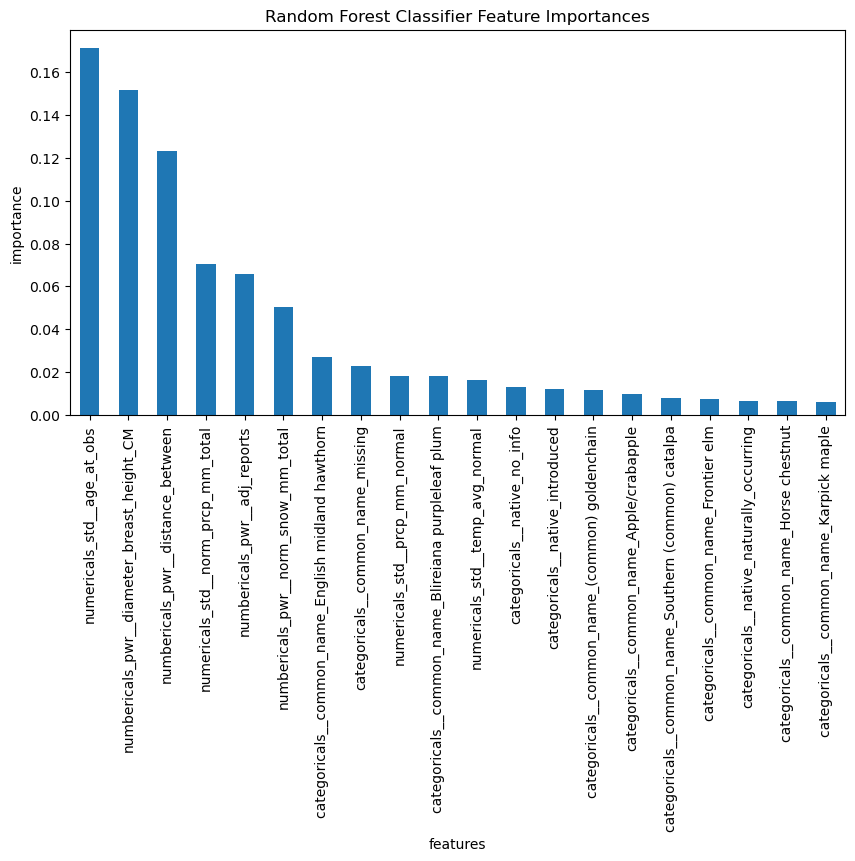

In [232]:
plt.subplots(figsize=(10, 5))

# Assuming the last step in your pipeline is the Random Forest model
rf_model = cv.best_estimator_[-1]

# Check if it's indeed a Random Forest model
if isinstance(rf_model, RandomForestClassifier):
    imps = rf_model.feature_importances_

    # Get the OneHotEncoder from the pipeline
    encoder = cv.best_estimator_[:-1].named_steps['preprocessing']
    
    # Get the original categorical column names
    categorical_columns = encoder.get_feature_names_out()
    
    # Create a series with categorical columns as index
    rf_feat_imps = pd.Series(imps, index=categorical_columns).sort_values(ascending=False)[:20]
    
    # Plot the feature importances
    rf_feat_imps.plot(kind='bar')
    plt.xlabel('features')
    plt.ylabel('importance')
    plt.title('Random Forest Classifier Feature Importances')
else:
    print("The last estimator in the pipeline is not a RandomForestClassifier.")

plt.show()


All that work on encoding the tree type and it's isn't too important. But I think it makes sense to include those values.

### 3.9.6 Learning Curve
We started with more than 100,000 records, but sampled down to 20,000 to save processing power. Let's checkout the learning curve to see if a larger sample would benefit the model.

Update -> Originally used 10,000 and saw some opportunity in the learning curve so updated to 20,000.

In [67]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(rf_final, X_res_scaled_coded, y_res_final, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

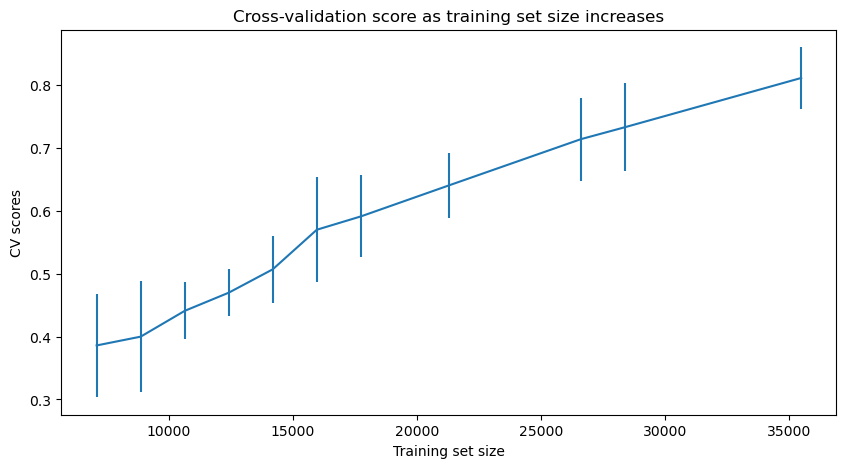

In [68]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases')
plt.show();

There is still more improvement to be had, likely even going beyond that 35,000 mark as the slope doesn't appear to be decreasing. We'll move onto our modeling stage and maybe even do a bit more tuning before moving completely into that phase.

## 4.0 Save Full Sample Data

### 4.0.0 Combine Train And Test Sets

In [233]:
#save original x and 7 splits (pre SMOTE and processing)

X_raw = X

y_raw = y

In [234]:
print(X_raw.shape, y_raw.shape)

(20000, 10) (20000,)


### 4.0.1 Save Data

In [78]:
# save trees data to a new csv
filepath = '../data/data_outputs/X_full_sample.csv'
X_raw.to_csv(filepath, index=False)

filepath2 = '../data/data_outputs/y_full_sample.csv'
y_raw.to_csv(filepath2, index=False)

## 4.1 Save Model

In [237]:
best_model = cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_res_final.columns]
best_model.build_datetime = dt.datetime.now()

In [248]:
# save the model

with open('../models/seattle_trees_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)